# MNIST using Generative Adversarial Networks (GANs)

## Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
from keras.datasets import mnist
from keras.optimizers import Adam
from tensorflow.keras import initializers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, Flatten, Dense, Reshape, LeakyReLU
from tensorflow.keras import Input, Model
import matplotlib.pyplot as plt
from tqdm import tqdm

## Loading the dataset

In [2]:
dim_random = 100

(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = ((X_train.astype(np.float32) - 127.5)/ 127.5).reshape(60000, 784)
print("Xtrain shape : ", X_train.shape)


11493376/11490434 [==============================] - 0s 0us/step
Xtrain shape :  (60000, 784)


## Building the GAN Model

In [3]:
# optimizer
adam = Adam(lr=0.0002, beta_1=0.5)


# defining generator
generator = Sequential()
generator.add(Dense(256, input_dim=dim_random,
                   kernel_initializer=initializers.RandomNormal(stddev=0.02)))
generator.add(LeakyReLU(0.2))
generator.add(Dense(512))
generator.add(LeakyReLU(0.2))
generator.add(Dense(1024))
generator.add(LeakyReLU(0.2))
generator.add(Dense(784, activation='tanh'))

# defining discriminator
disc = Sequential()
disc.add(Dense(1024, input_dim=784, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
disc.add(LeakyReLU(0.2))
disc.add(Dropout(0.3))
disc.add(Dense(512))
disc.add(LeakyReLU(0.2))
disc.add(Dropout(0.3))
disc.add(Dense(256))
disc.add(LeakyReLU(0.2))
disc.add(Dropout(0.3))
disc.add(Dense(1, activation='sigmoid'))
disc.compile(loss='binary_crossentropy', optimizer=adam)

# combining the two models to get the whole network
disc.trainable = False
# defining an object of input with shape same as that of random vector
ganInput = Input(shape=(dim_random,))
# getting generator output in x with input as ganinput
x = generator(ganInput)
# getting output from discriminator
ganOutput = disc(x)
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=adam)

## Defining a function to plot the losses and generated images

In [4]:
# defining lists to store the losses of the discriminator and generator
dlosses = []
glosses = []

# plotting loss from each batch
def plotLossBatch(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dlosses, label='Disc. loss')
    plt.plot(glosses, label='Gen. loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    

# plotting the generated images
def plotGenImg(epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, dim_random])
    genimgs = generator.predict(noise)
    genimgs = genimgs.reshape(examples, 28, 28)
    plt.figure(figsize=figsize)
    
    for i in range(genimgs.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(genimgs[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
        plt.tight_layout()

## Defining the Training function

In [5]:
def train(epochs=1, batchsize=128):
    batch_count = X_train.shape[0] / batchsize
    print("Epochs train : ", epochs)
    print("batchsize train : ", batchsize)
    print("btach count train : ", batch_count)
    
    for e in range(1, epochs + 1):
        print("-" * 50)
        print("Epoch {}".format(e))
        
        for _ in tqdm(range(int(batch_count))):
            # using a random set of images and noise as input
            noise = np.random.normal(0, 1, size=[batchsize, dim_random])
            imgbatch = X_train[np.random.randint(0, X_train.shape[0], size=batchsize)]
            
            # generating fake images
            genimgs = generator.predict(noise)
            X = np.concatenate([imgbatch, genimgs])
            ydisc = np.zeros(2*batchsize)
            ydisc[:batchsize] = 0.9
            
            # training discriminator
            disc.trainable = True
            dloss = disc.train_on_batch(X, ydisc)
            
            # training generator
            noise = np.random.normal(0, 1, size=[batchsize, dim_random])
            ygen = np.ones(batchsize)
            disc.trainable = False
            gloss = gan.train_on_batch(noise, ygen)
        
        dlosses.append(dloss)
        glosses.append(gloss)
        
        if e == 1 or e % 20 == 0:
            plotGenImg(e)
    
    plotLossBatch(e)

  0%|          | 0/468 [00:00<?, ?it/s]

Epochs train :  20
batchsize train :  128
btach count train :  468.75
--------------------------------------------------
Epoch 1


  1%|          | 3/468 [00:00<00:19, 23.76it/s]

--------------------------------------------------
Epoch 2


  1%|          | 3/468 [00:00<00:18, 24.57it/s]

--------------------------------------------------
Epoch 3


  1%|          | 3/468 [00:00<00:19, 23.31it/s]

--------------------------------------------------
Epoch 4


  1%|          | 3/468 [00:00<00:19, 24.29it/s]

--------------------------------------------------
Epoch 5


  1%|          | 3/468 [00:00<00:19, 23.66it/s]

--------------------------------------------------
Epoch 6


  1%|          | 3/468 [00:00<00:18, 24.63it/s]

--------------------------------------------------
Epoch 7


  1%|          | 3/468 [00:00<00:19, 24.23it/s]

--------------------------------------------------
Epoch 8


  0%|          | 2/468 [00:00<00:29, 15.86it/s]

--------------------------------------------------
Epoch 9


  1%|          | 3/468 [00:00<00:19, 24.25it/s]

--------------------------------------------------
Epoch 10


  1%|          | 3/468 [00:00<00:19, 24.06it/s]

--------------------------------------------------
Epoch 11


  1%|          | 3/468 [00:00<00:19, 23.42it/s]

--------------------------------------------------
Epoch 12


  1%|          | 3/468 [00:00<00:19, 23.57it/s]

--------------------------------------------------
Epoch 13


  1%|          | 3/468 [00:00<00:19, 23.37it/s]

--------------------------------------------------
Epoch 14


  1%|          | 3/468 [00:00<00:19, 24.17it/s]

--------------------------------------------------
Epoch 15


  1%|          | 3/468 [00:00<00:19, 23.72it/s]

--------------------------------------------------
Epoch 16


  1%|          | 3/468 [00:00<00:20, 23.10it/s]

--------------------------------------------------
Epoch 17


  1%|          | 3/468 [00:00<00:19, 23.73it/s]

--------------------------------------------------
Epoch 18


  1%|          | 3/468 [00:00<00:19, 24.13it/s]

--------------------------------------------------
Epoch 19


  1%|          | 3/468 [00:00<00:18, 24.85it/s]

--------------------------------------------------
Epoch 20


100%|██████████| 468/468 [00:20<00:00, 22.76it/s]


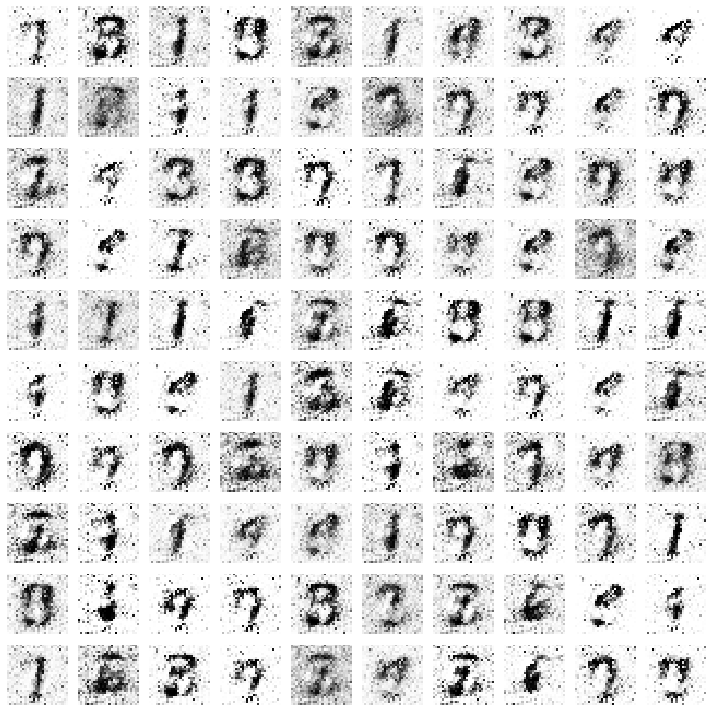

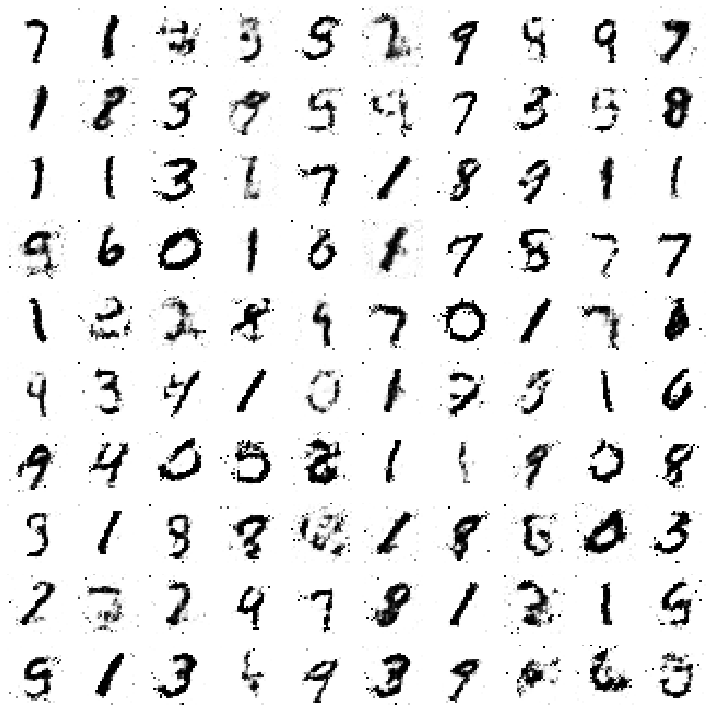

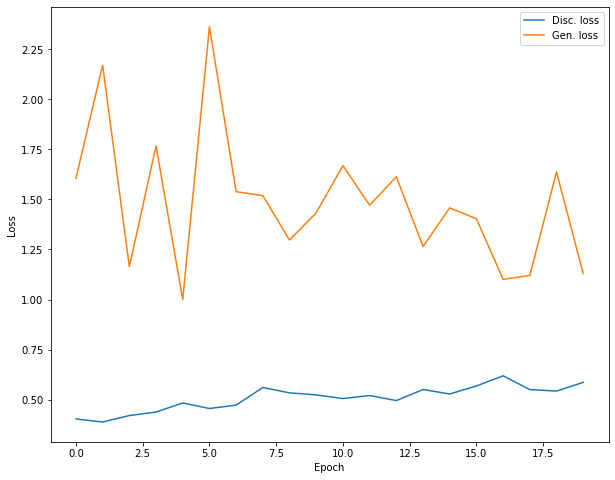

In [6]:
train(20, 128)